<a href="https://colab.research.google.com/github/oliverwsd/LSTM_AE/blob/master/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import urllib.request, json 

# _ preferences
plt.rcParams['figure.figsize'] = (30.0, 10.0)
plt.style.use('ggplot')

from keras.optimizers       import Adam
from keras.models           import Sequential
from keras.layers           import Dense
from keras.layers           import LSTM, RepeatVector, TimeDistributed,Dropout
from keras.models           import load_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
#train_set = pd.read_csv('train_set.csv',parse_dates= ['Date'])
train_set = 'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/train_set.csv'
train_set = pd.read_csv(train_set,parse_dates= ['Date'])

In [3]:
train_set.index = train_set['Date']
train_set = train_set.drop(['Date'],axis=1)

In [4]:
train_set.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029


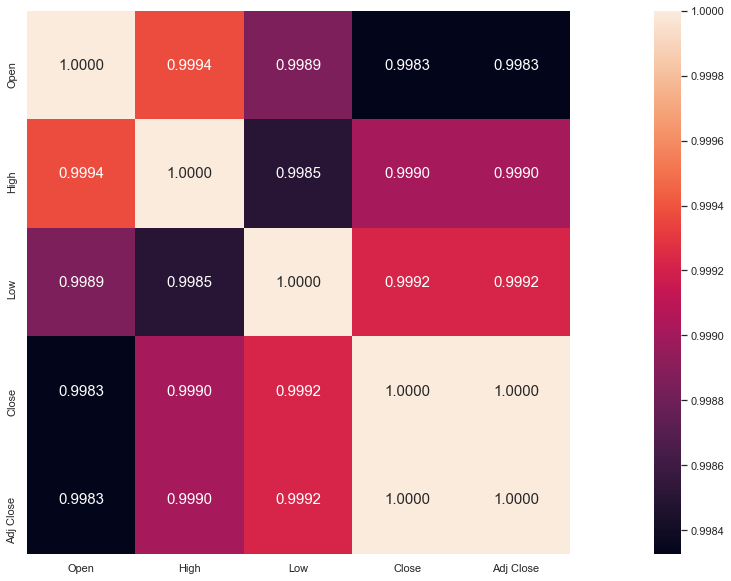

In [ ]:
import seaborn as sns
cm = np.corrcoef(train_set.values.T)   
sns.set(font_scale=1)   
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=train_set.columns,xticklabels=train_set.columns)
#plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)


In [ ]:
#test_set = pd.read_csv('test_set.csv',parse_dates= ['Date'])
test_set = 'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/test_set.csv'
test_set = pd.read_csv(test_set,parse_dates= ['Date'])

In [ ]:
test_set.index = test_set['Date']
test_set = test_set.drop(['Date'],axis=1)

In [ ]:
test_set.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-08-27,2893.139893,2898.790039,2860.590088,2869.159912,2869.159912
2019-08-28,2861.280029,2890.030029,2853.050049,2887.939941,2887.939941
2019-08-29,2910.370117,2930.500000,2905.669922,2924.580078,2924.580078
2019-08-30,2937.090088,2940.429932,2913.320068,2926.459961,2926.459961
2019-09-03,2909.010010,2914.389893,2891.850098,2906.270020,2906.270020


#  preprocessing data

In [ ]:
sc = MinMaxScaler(feature_range = (0,1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.fit_transform(test_set)

In [ ]:
train_set_scaled = pd.DataFrame(train_set_scaled,columns=train_set.columns)

In [ ]:
test_set_scaled = pd.DataFrame(test_set_scaled,columns=train_set.columns)

In [ ]:
# preparing data for LSTM-AE
# we consider an embedding layer instead of feeding the entire seires into the model at once
# therefore we split data into smaller peices in an constant window to create a smaller seires of observertion for prediction

def normalize_data(X, Y, LOOKBACK_WINDOW):
    _X = X.dropna()
    _Xs = []
    _Ys = []
    for i in range(_X.shape[0] - LOOKBACK_WINDOW):
        cur_X = _X.values[i:i + LOOKBACK_WINDOW]
        _Xs.append(cur_X)
        
        y_pointer = i + LOOKBACK_WINDOW
        cur_Y = Y.values[y_pointer]
        _Ys.append(cur_Y)
    return np.array(_Xs), np.array(_Ys)

In [ ]:
#x_train, y_train = normalize_data(train_set_scaled, train_set_scaled['Adj Close'], 23)
#x_test, y_test = normalize_data(test_set_scaled, test_set_scaled['Adj Close'], 23)

In [ ]:
x_train, y_train = normalize_data(train_set_scaled, train_set_scaled['Adj Close'], 10)
x_test, y_test = normalize_data(test_set_scaled, test_set_scaled['Adj Close'], 10)

In [ ]:
y_train = y_train.reshape(y_train.shape[0],1)

# Reconstruct-Model

###  We use LSTM-AE to reconstruct the market index 
the encoder is supposed to extract the hidden feature from the input data, hence helps us to reduce the data dimension

In [ ]:
timesteps = x_train.shape[1]
n_features = x_train.shape[2]

In [ ]:
model = Sequential()
model.add(LSTM(128,activation='relu',input_shape= (timesteps,n_features),return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(1,activation='relu'))
model.add(RepeatVector(timesteps))
model.add(LSTM(64,activation='relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 128)           68608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 264       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 1)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 64)           

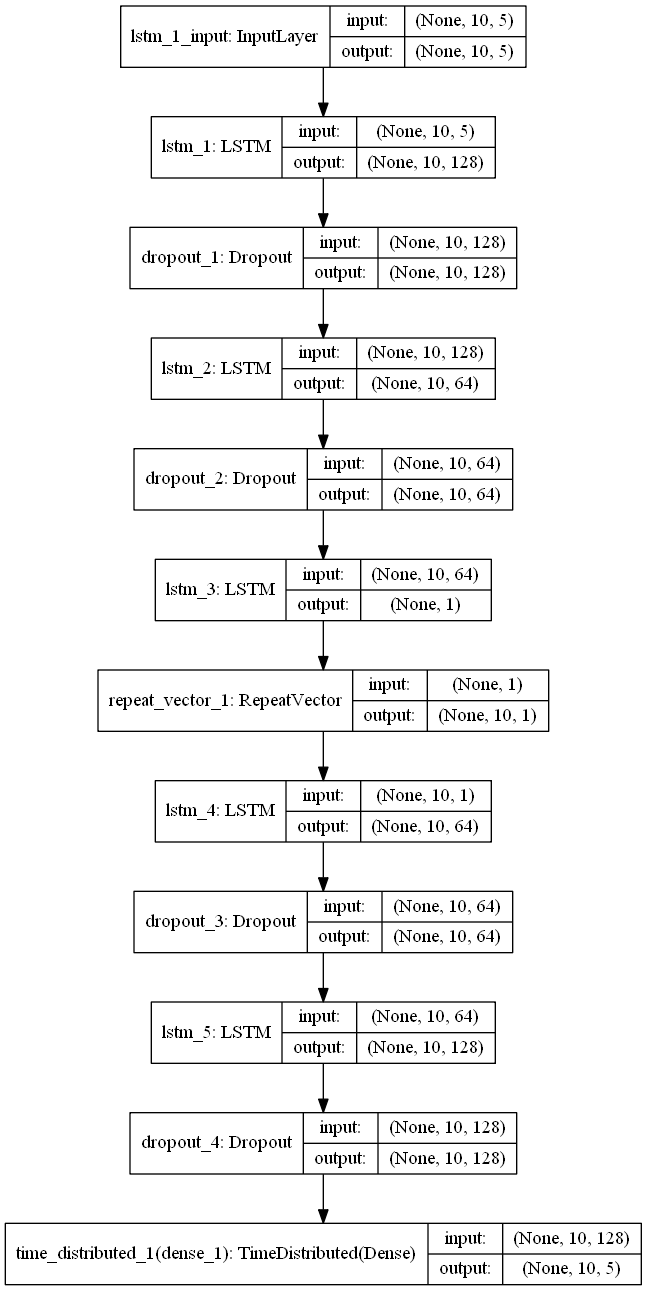

In [ ]:
from keras.models import  Model
from keras.utils import plot_model
encoder = Model(inputs=model.inputs, outputs=model.layers[4].output)
plot_model(model, show_shapes=True, to_file='encoder_decoder_reconstruct_lstm.png')

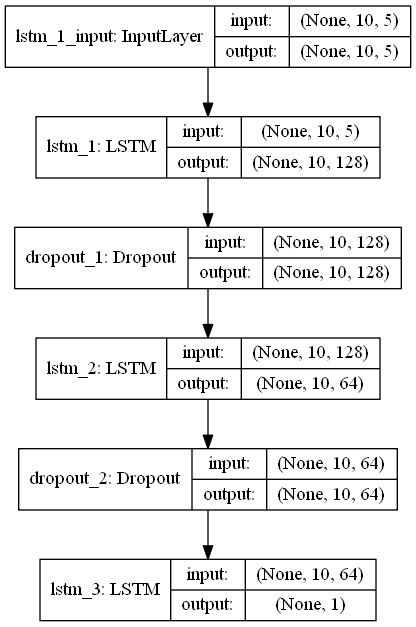

In [ ]:
plot_model(encoder, show_shapes=True, to_file='encoder_lstm.png')

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # EarlyStopping
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
history_1 = model.fit(x_train, x_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)

Train on 817 samples, validate on 91 samples
Epoch 1/100
817/817 [==============================] - 2s 3ms/step - loss: 0.2085 - val_loss: 0.3369
Epoch 2/100
817/817 [==============================] - 1s 1ms/step - loss: 0.0938 - val_loss: 0.1701
Epoch 3/100
817/817 [==============================] - 1s 1ms/step - loss: 0.0548 - val_loss: 0.0719
Epoch 4/100
817/817 [==============================] - 1s 1ms/step - loss: 0.0246 - val_loss: 0.0169
Epoch 5/100
817/817 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0054
Epoch 6/100
817/817 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0069
Epoch 7/100
817/817 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0087
Epoch 8/100
817/817 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0069
Epoch 9/100
817/817 [==============================] - 1s 1ms/step - loss: 0.0053 - val_loss: 0.0074
Epoch 10/100
817/817 [========================

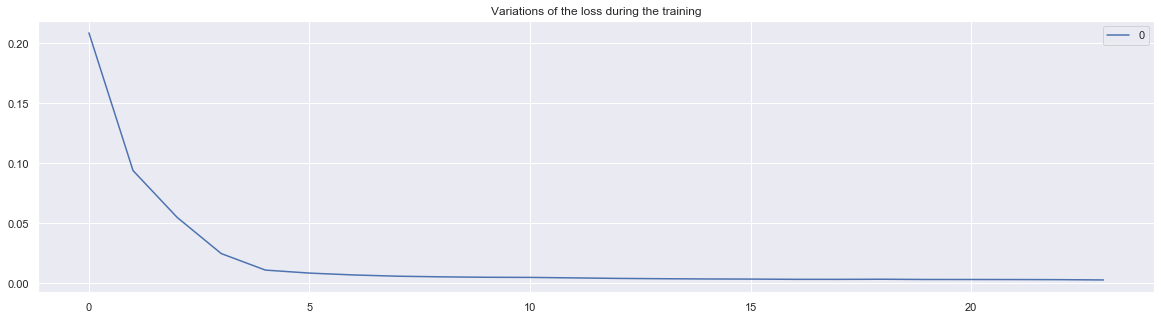

In [ ]:
pd.DataFrame(history_1.history['loss']).plot(figsize=(20,5))
plt.grid(True)
plt.title('Variations of the loss during the training')
plt.show()

In [ ]:
model.evaluate(x_test, x_test, verbose=1)

185/185 [==============================] - 0s 422us/step


0.004798467705856908

In [ ]:
test_prediction = model.predict(x_test)

In [ ]:
# compare mse between prediciton and target
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
rmse(test_prediction, x_test)

0.06927097438432628

# Encoder-Model

In [ ]:
train_encoded = encoder.predict(x_train)
test_encoded = encoder.predict(x_test)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (908, 1)
Encoded time-series sample [0.08384668]


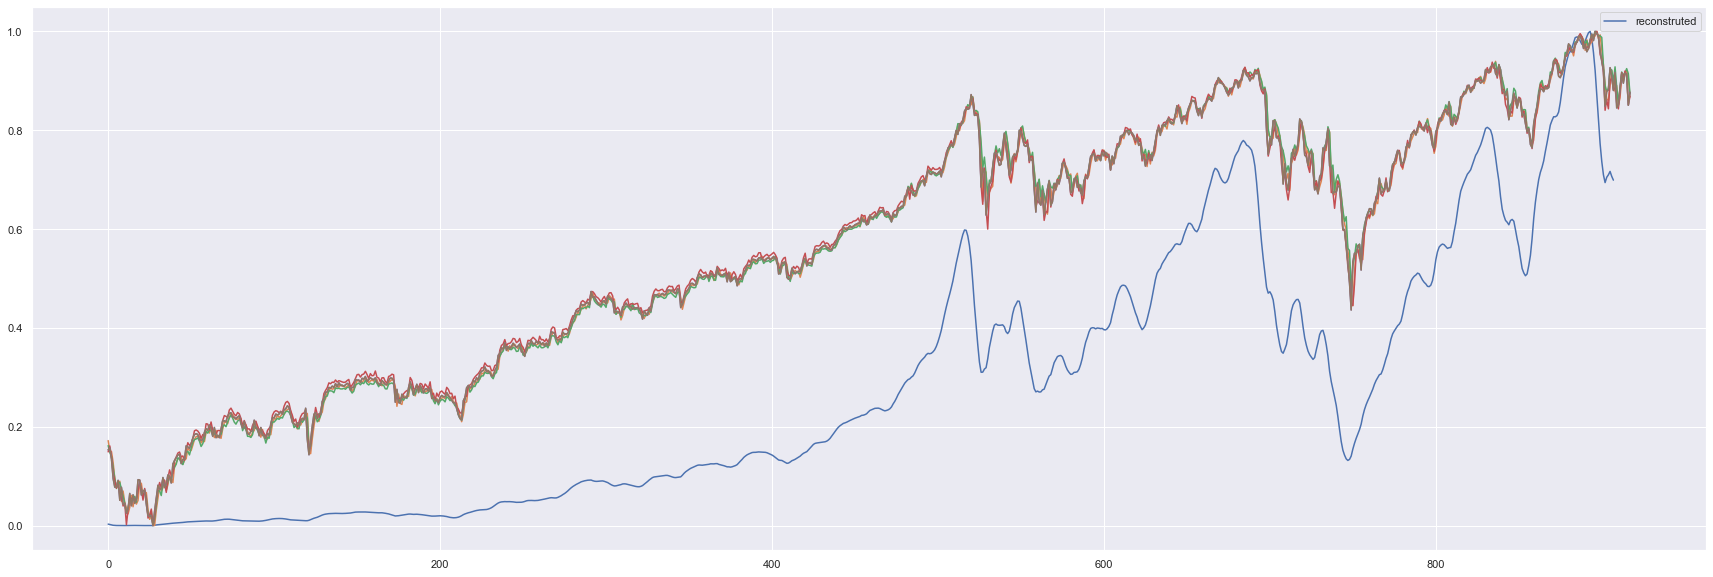

In [ ]:
train_encoded_scaled = sc.fit_transform(train_encoded)
plt.plot(train_encoded_scaled,label='reconstruted')
plt.plot(train_set_scaled.values[:])
plt.legend()

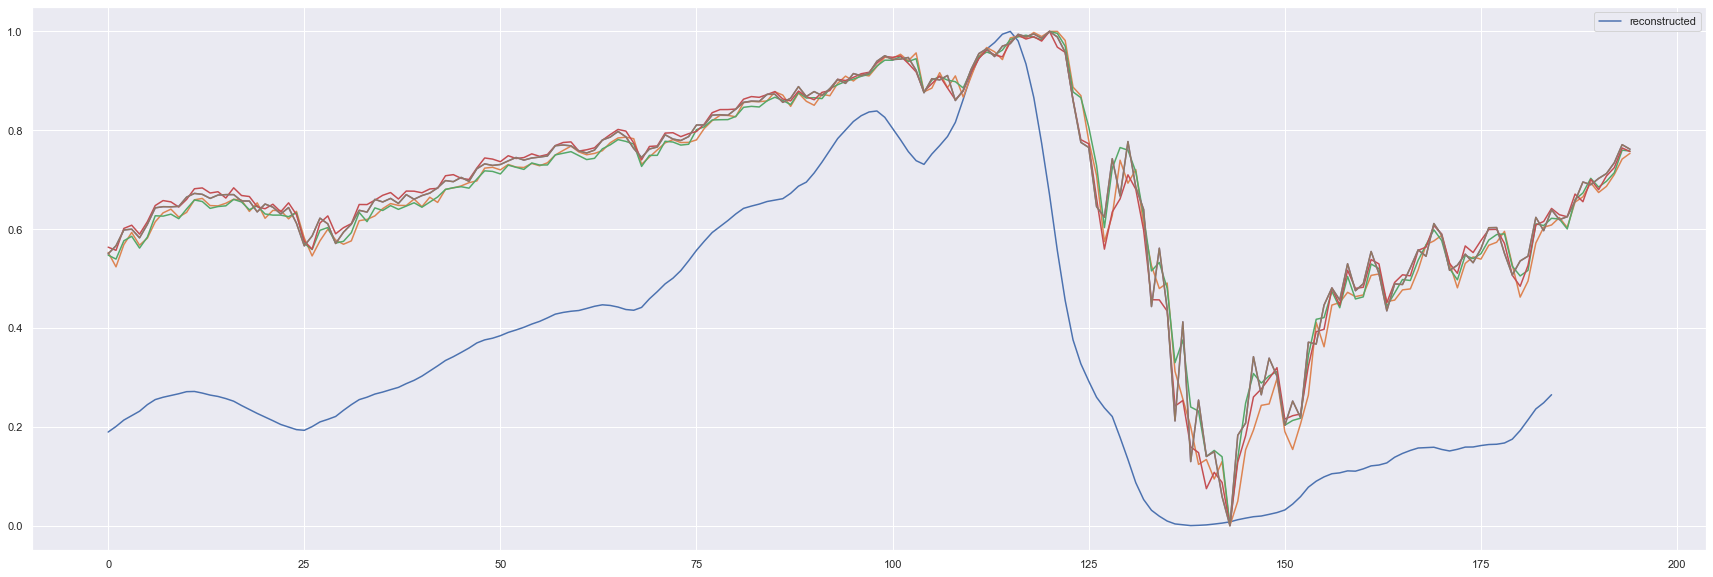

In [ ]:
test_encoded_scaled = sc.fit_transform(test_encoded)
plt.plot(test_encoded_scaled, label='reconstructed')
plt.plot(test_set_scaled.values[:])
plt.legend()

# Prediction-Model 

## Using compressed features from encoder to predict the future index

In [ ]:
#x1_train, y1_train = normalize_data(train_set_scaled['Adj Close'], train_set_scaled['Adj Close'], 23)
#x1_test, y1_test = normalize_data(test_set_scaled['Adj Close'], test_set_scaled['Adj Close'], 23)

In [ ]:
x1_train, y1_train = normalize_data(train_set_scaled['Adj Close'], train_set_scaled['Adj Close'], 10)
x1_test, y1_test = normalize_data(test_set_scaled['Adj Close'], test_set_scaled['Adj Close'], 10)

In [ ]:
# train data 
x1_train = x1_train.reshape(x1_train.shape[0],x1_train.shape[1])
#compressed_train = pd.DataFrame(x1_train, columns= range(1,24))
compressed_train = pd.DataFrame(x1_train, columns= range(1,11))
#compressed_train['encoder'] = train_encoded_scaled
compressed_train['encoder'] = train_encoded
compressed_train['target']= y1_train

In [ ]:
# Train data
x_train_encoded = np.array(compressed_train[['encoder',10,9,8,7]])
#x_train_encoded = np.array(compressed_train[['encoder',23,22,21,20]])
#x_train_encoded_2 = np.array(compressed_train[['encoder',22,20,18,16]])
y_train_encoded = np.array(compressed_train['target'])

x_train_encoded = x_train_encoded.reshape(x_train_encoded.shape[0],x_train_encoded.shape[1],1)
#x_train_encoded_2 = x_train_encoded_2.reshape(x_train_encoded_2.shape[0],x_train_encoded_2.shape[1],1)

In [ ]:
# test data 
x1_test = x1_test.reshape(x1_test.shape[0],x1_test.shape[1])
# compressed_test = pd.DataFrame(x1_test, columns= range(1,24))
compressed_test = pd.DataFrame(x1_test, columns= range(1,11))
compressed_test['encoder'] = test_encoded
compressed_test['target']= y1_test

x_test_encoded = np.array(compressed_test[['encoder',10,9,8,7]])
#x_test_encoded = np.array(compressed_test[['encoder',23,22,21,20]])
#x_test_encoded_2 = np.array(compressed_test[['encoder',22,20,18,16]])
y_test_encoded = np.array(compressed_test['target'])
x_test_encoded = x_test_encoded.reshape(x_test_encoded.shape[0],x_test_encoded.shape[1],1)
#x_test_encoded_2 = x_test_encoded_2.reshape(x_test_encoded_2.shape[0],x_test_encoded_2.shape[1],1)

In [ ]:
# LSTM-AE
timesteps = x_train_encoded.shape[1]
n_features = x_train_encoded.shape[2]

model2 = Sequential()
model2.add(LSTM(128,activation='relu',input_shape= (timesteps,n_features),return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(64,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='linear'))

model2.compile(optimizer='adam',loss='mse')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_2 = model2.fit(x_train_encoded, y_train_encoded, epochs=50, batch_size= 32, validation_split=0.1, callbacks=[es], verbose=1)

Train on 817 samples, validate on 91 samples
Epoch 1/50
817/817 [==============================] - 1s 1ms/step - loss: 0.0883 - val_loss: 0.0177
Epoch 2/50
817/817 [==============================] - 0s 261us/step - loss: 0.0136 - val_loss: 0.0058
Epoch 3/50
817/817 [==============================] - 0s 295us/step - loss: 0.0090 - val_loss: 0.0022
Epoch 4/50
817/817 [==============================] - 0s 268us/step - loss: 0.0061 - val_loss: 0.0028
Epoch 5/50
817/817 [==============================] - 0s 300us/step - loss: 0.0055 - val_loss: 0.0044
Epoch 6/50
817/817 [==============================] - 0s 279us/step - loss: 0.0047 - val_loss: 0.0117
Epoch 7/50
817/817 [==============================] - 0s 260us/step - loss: 0.0048 - val_loss: 0.0024
Epoch 8/50
817/817 [==============================] - 0s 295us/step - loss: 0.0043 - val_loss: 0.0090
Epoch 9/50
817/817 [==============================] - 0s 278us/step - loss: 0.0044 - val_loss: 0.0023
Epoch 10/50
817/817 [==================

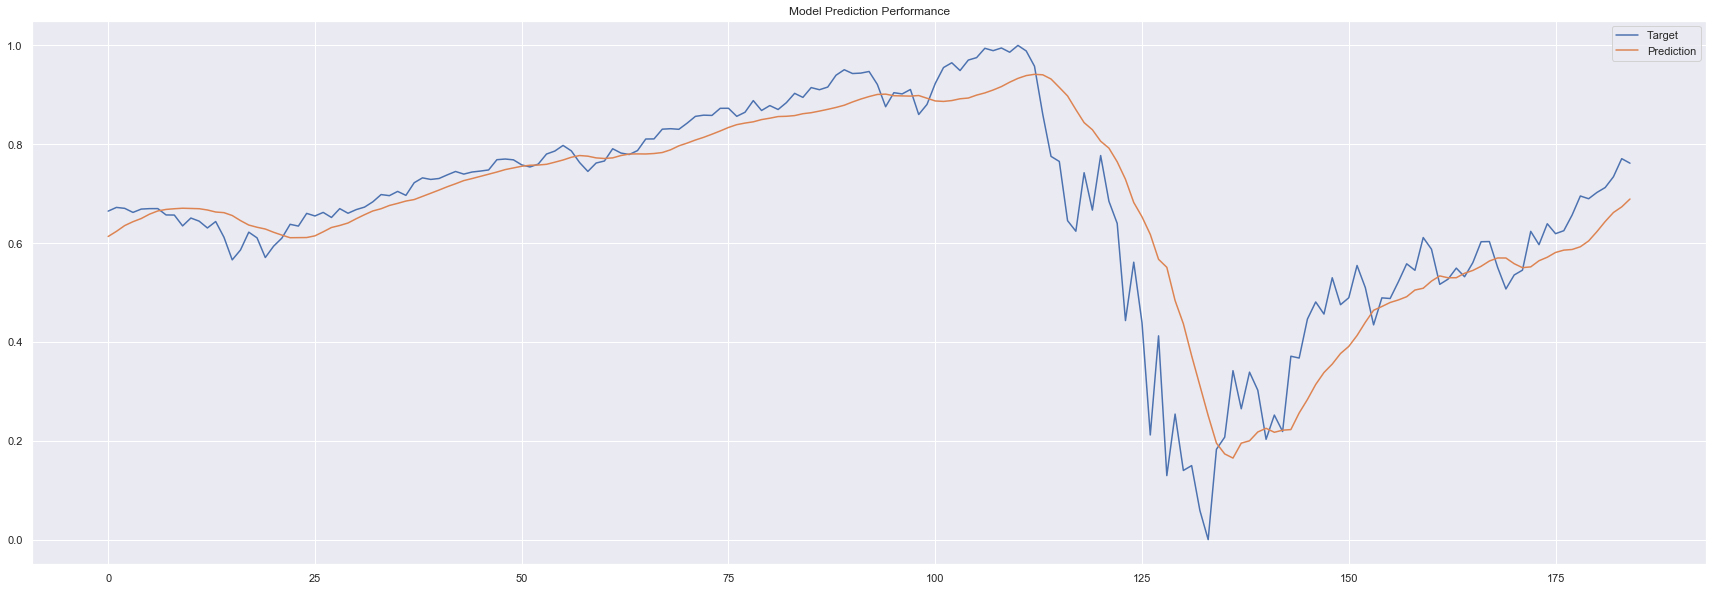

In [ ]:
test_prediction = model2.predict(x_test_encoded)
plt.plot(y_test_encoded,label='Target')
plt.plot(test_prediction,label='Prediction')
plt.title('Model Prediction Performance')
plt.legend()

In [ ]:
df = pd.DataFrame()
df['target'] = y_test_encoded
df['prediction'] = test_prediction.reshape(test_prediction.shape[0])
df['encoder'] = test_encoded

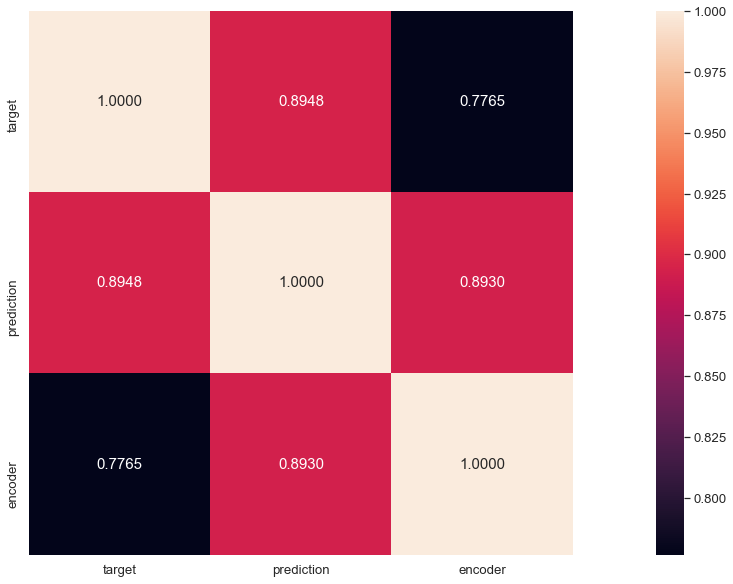

In [ ]:
cm = np.corrcoef(df.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df.columns,xticklabels=df.columns)
#plt.tight_layout()
plt.savefig('corr_mat.png', dpi=300)

# Prediction-Model 2
## Out-of-Sample

In [ ]:
#x_test, y_test = normalize_data(test_set_scaled, test_set_scaled['Adj Close'], 23)
#x_test_encoded = np.array(compressed_test[['encoder',23,22,21,20]])

x_test, y_test = normalize_data(test_set_scaled, test_set_scaled['Adj Close'], 10)
x_test_encoded = np.array(compressed_test[['encoder',10,9,8,7]])

In [ ]:
pred = []
test = x_test_encoded[0].reshape(1,x_train_encoded.shape[1],x_train_encoded.shape[2])
test_prediction = model2.predict(test)
pred.append(test_prediction)

In [ ]:
test[0,4]= test[0,3]
test[0,3]= test[0,2]
test[0,2]= test[0,1]
test[0,1]= pred[-1]
x_test[1,9] = [pred[-1],pred[-1],pred[-1],pred[-1],pred[-1]]
encoder_value = encoder.predict(x_test[1].reshape(1,x_test.shape[1],x_test.shape[2]))
#encoder_value = sc.fit_transform(encoder_value)
test[0,0]= encoder_value
test_prediction = model2.predict(test)
pred.append(test_prediction)

In [ ]:
for i in range(1,len(x_test_encoded)):
    #test = x_test_encoded[i].reshape(1,x_train_encoded.shape[1],x_train_encoded.shape[2])
    test[0,4]= test[0,3]
    test[0,3]= test[0,2]
    test[0,2]= test[0,1]
    test[0,1]= pred[-1]
    x_test[i,9] = [pred[-1],pred[-1],pred[-1],pred[-1],pred[-1]]
    encoder_value = encoder.predict(x_test[i].reshape(1,x_test.shape[1],x_test.shape[2]))  
    test[0,0]= encoder_value
    test_prediction = model2.predict(test)
    pred.append(test_prediction)
    
array_pred = np.array(pred)
df_pred = pd.DataFrame(array_pred.reshape(len(pred)))

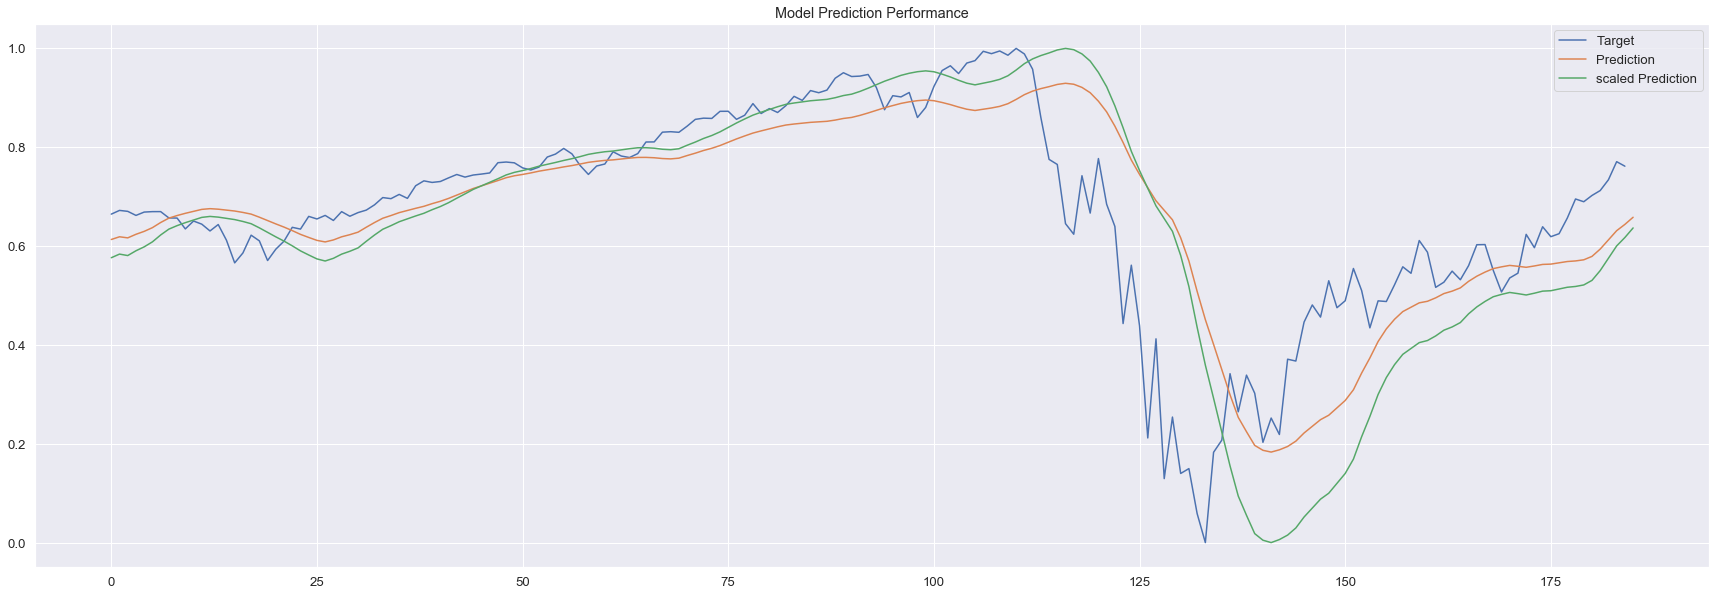

In [ ]:
plt.plot(y_test_encoded,label='Target')
df_pred_scaled = sc.fit_transform(df_pred)
plt.plot(df_pred,label='Prediction')
plt.plot(df_pred_scaled[:],label='scaled Prediction')
plt.title('Model Prediction Performance')
plt.legend()

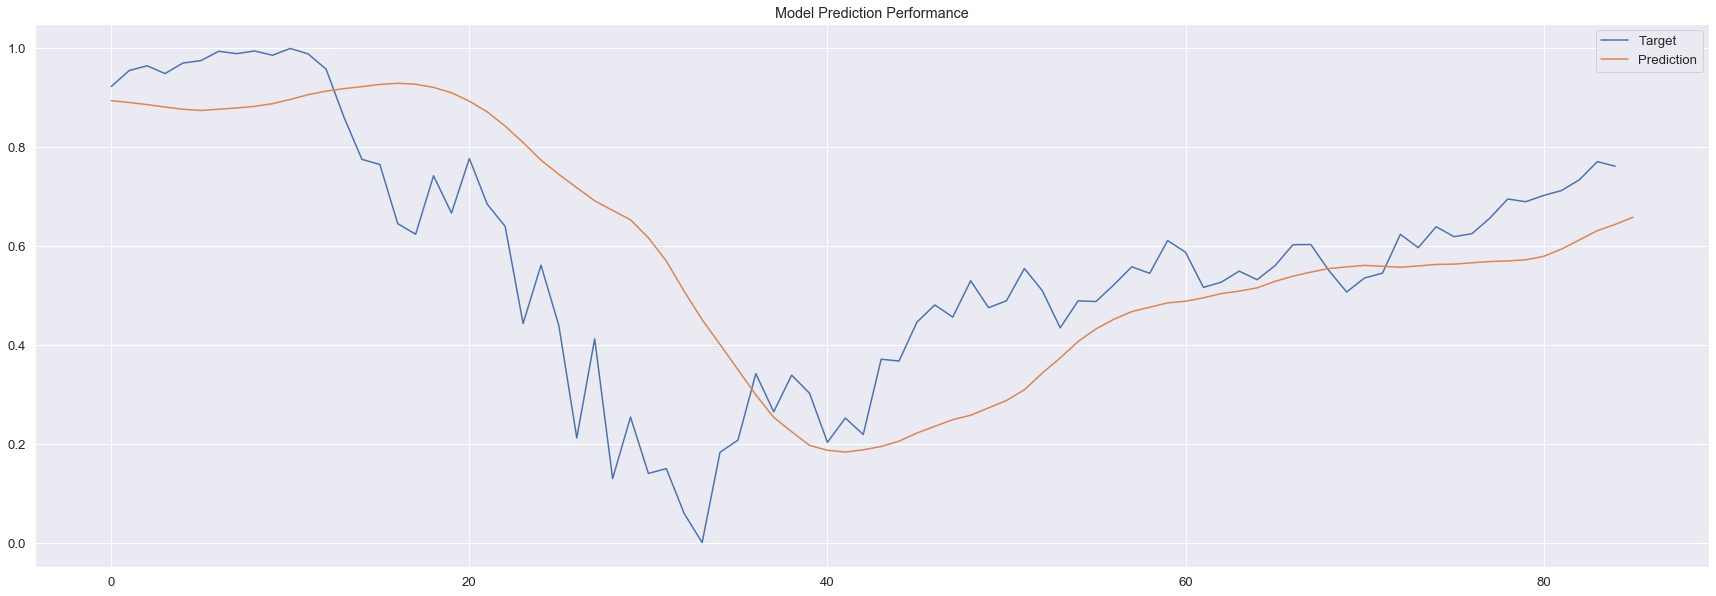

In [ ]:
plt.plot(y_test_encoded[100:],label='Target')
plt.plot(df_pred.values[100:],label='Prediction')
#plt.plot(df_pred_scaled[100:],label='scaled Prediction')
plt.title('Model Prediction Performance')
plt.legend()

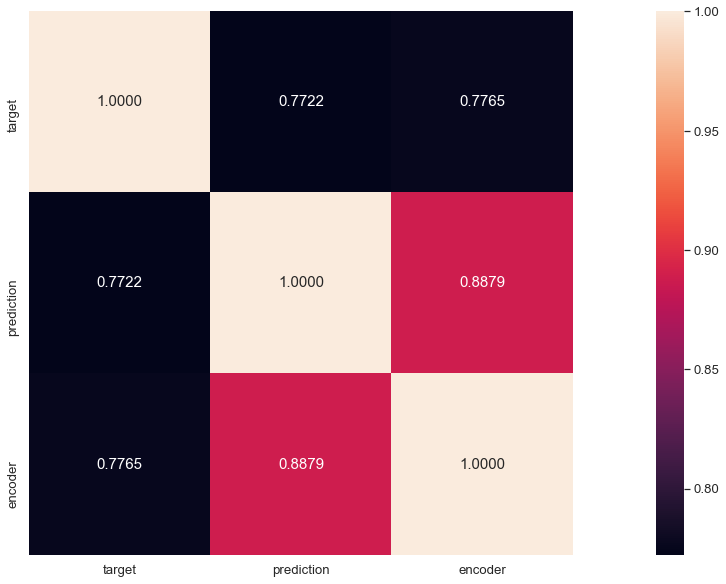

In [ ]:
df3 = pd.DataFrame()
df3['target'] = y_test_encoded
df3['prediction'] = df_pred_scaled[:-1]
df3['encoder'] = test_encoded

cm = np.corrcoef(df3.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df3.columns,xticklabels=df3.columns)
#plt.tight_layout()
#plt.savefig('corr_mat.png', dpi=300)

# Improved Prediction-Model
## Additional features, e.g commonal stocks, least commonal stocks

In [ ]:
# inspired by the deep portfolio theory, which is capable to reconstruct the market index with limited components
# we plan to put the 5 most communal stocks into the LSTM-AE to extract the pf's hidden features from the encoder
# as well as the 5 least communal stocks to capture the market volatiles

### most communal stocks

In [ ]:
c_train_scaled = pd.read_csv('communal_train_scaled.csv',index_col=0)
c_test_scaled =  pd.read_csv('communal_test_scaled.csv',index_col=0)

#c_x_train, c_y_train = normalize_data(c_train_scaled, train_set_scaled['Adj Close'], 23)
#c_x_test, c_y_test = normalize_data(c_test_scaled, test_set_scaled['Adj Close'], 23)

c_x_train, c_y_train = normalize_data(c_train_scaled, train_set_scaled['Adj Close'], 10)
c_x_test, c_y_test = normalize_data(c_test_scaled, test_set_scaled['Adj Close'], 10)

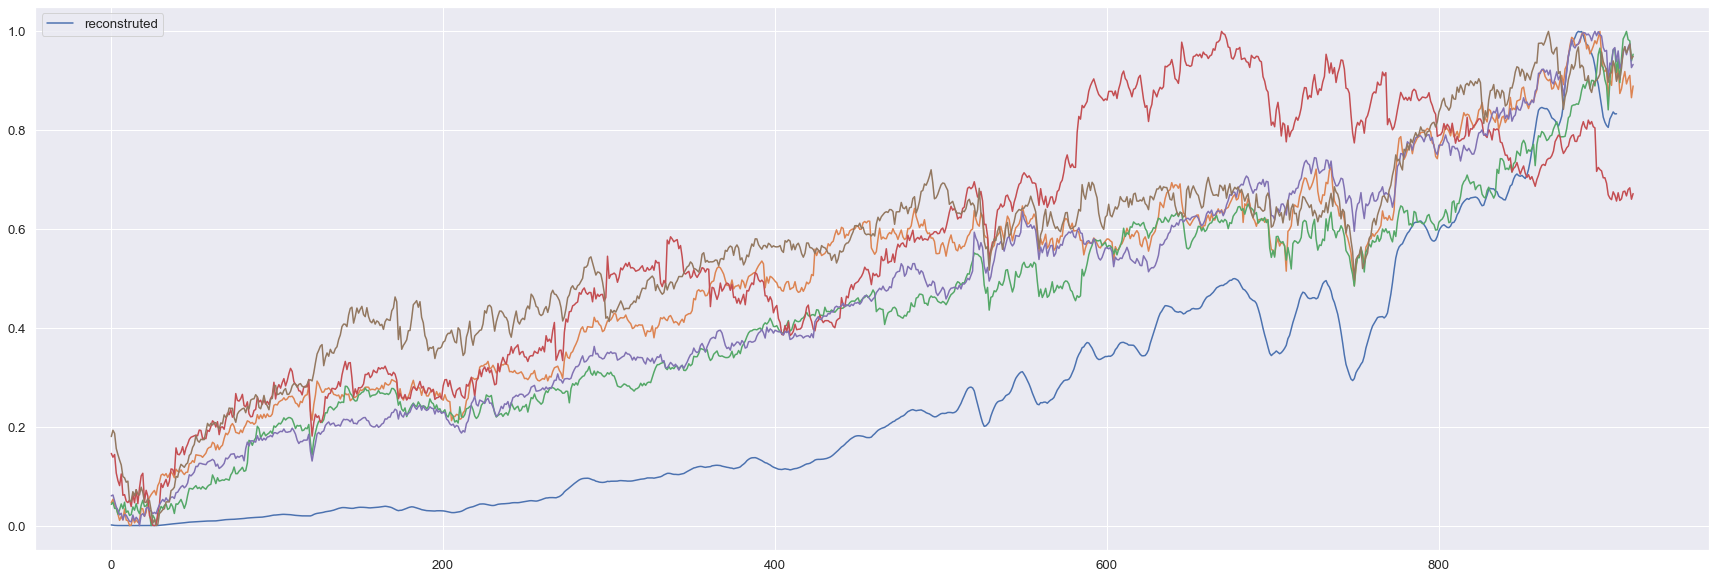

In [ ]:
c_train_encoded = encoder.predict(c_x_train)
c_train_encoded_scaled = sc.fit_transform(c_train_encoded)
plt.plot(c_train_encoded_scaled,label='reconstruted')
plt.plot(c_train_scaled.values[:])
plt.legend()

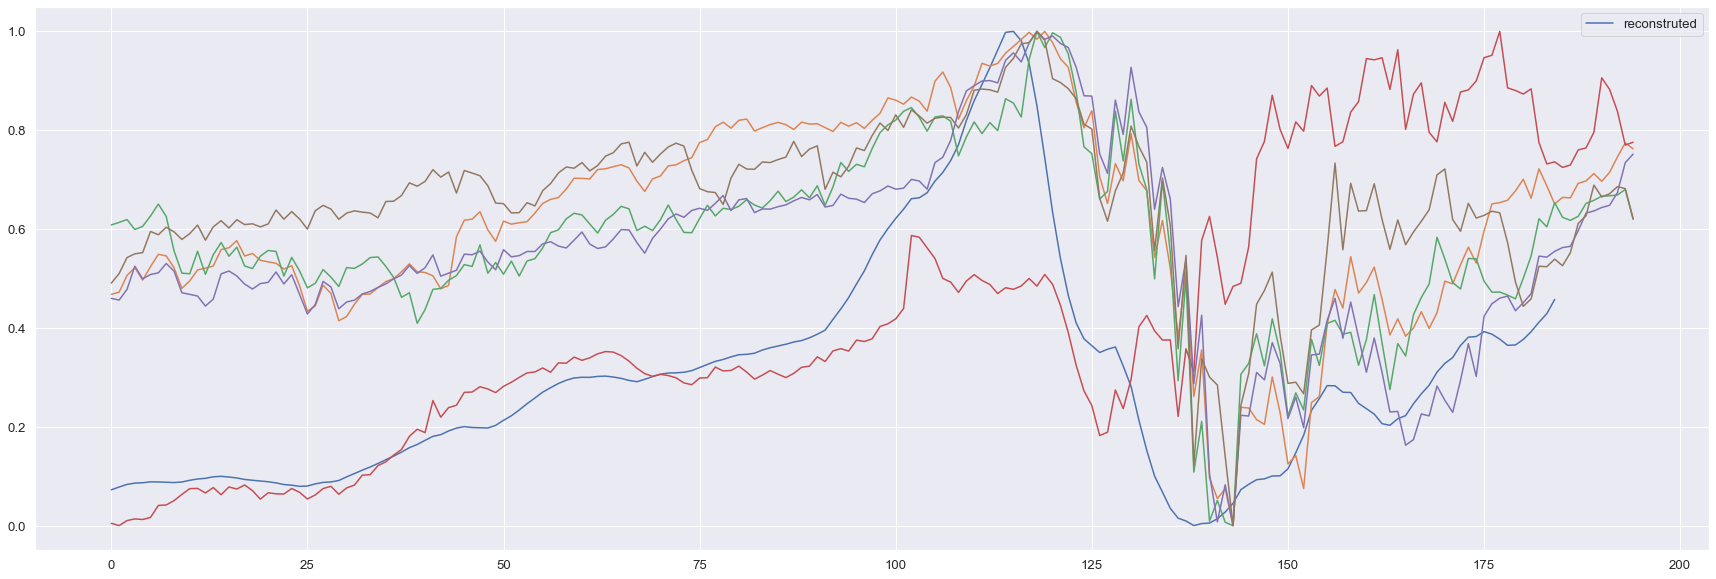

In [ ]:
c_test_encoded = encoder.predict(c_x_test)
c_test_encoded_scaled = sc.fit_transform(c_test_encoded)
plt.plot(c_test_encoded_scaled,label='reconstruted')
plt.plot(c_test_scaled.values[:])
plt.legend()

### least communal stocks

In [ ]:
l_train_scaled = pd.read_csv('least_communal_train_scaled.csv',index_col=0)
l_test_scaled =  pd.read_csv('least_communal_test_scaled.csv',index_col=0)

#l_x_train, l_y_train = normalize_data(l_train_scaled, train_set_scaled['Adj Close'], 23)
#l_x_test, l_y_test = normalize_data(l_test_scaled, test_set_scaled['Adj Close'], 23)

l_x_train, l_y_train = normalize_data(l_train_scaled, train_set_scaled['Adj Close'], 10)
l_x_test, l_y_test = normalize_data(l_test_scaled, test_set_scaled['Adj Close'], 10)

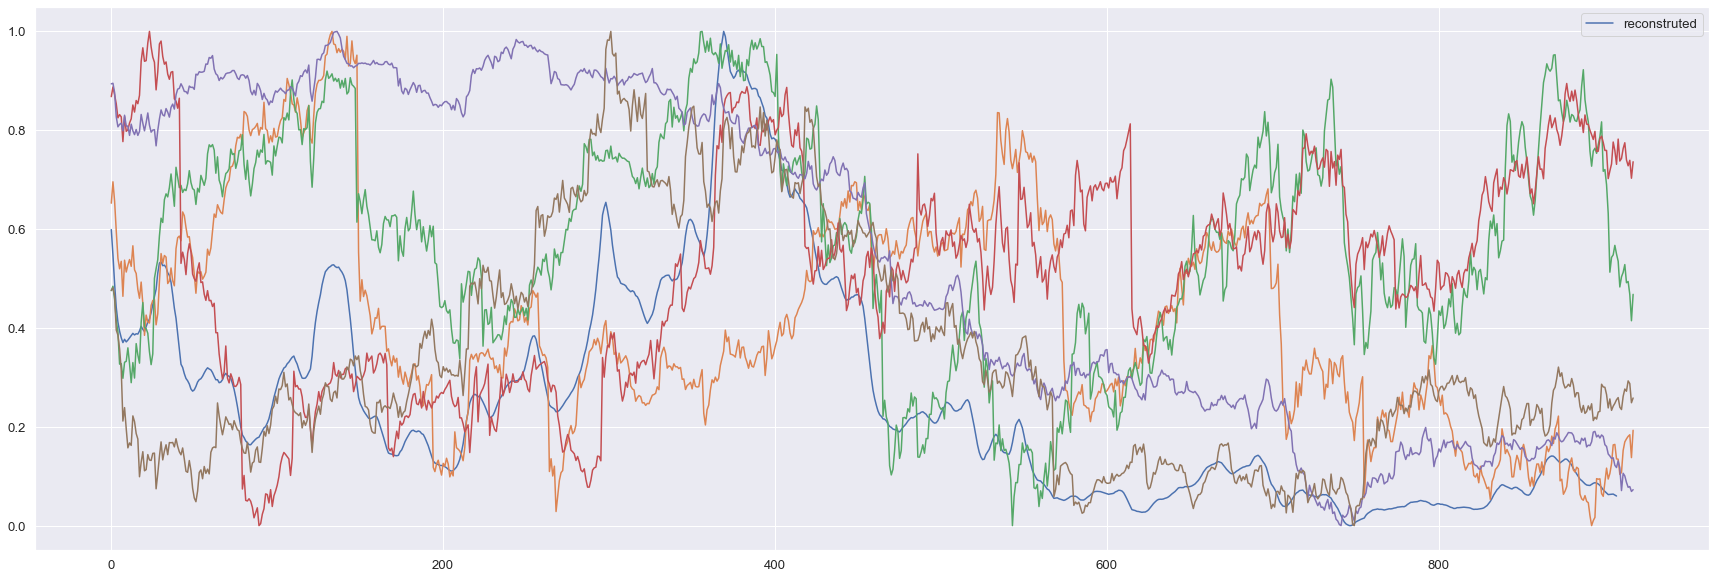

In [ ]:
l_train_encoded = encoder.predict(l_x_train)
l_train_encoded_scaled = sc.fit_transform(l_train_encoded)
plt.plot(l_train_encoded_scaled,label='reconstruted')
plt.plot(l_train_scaled.values[:])
plt.legend()

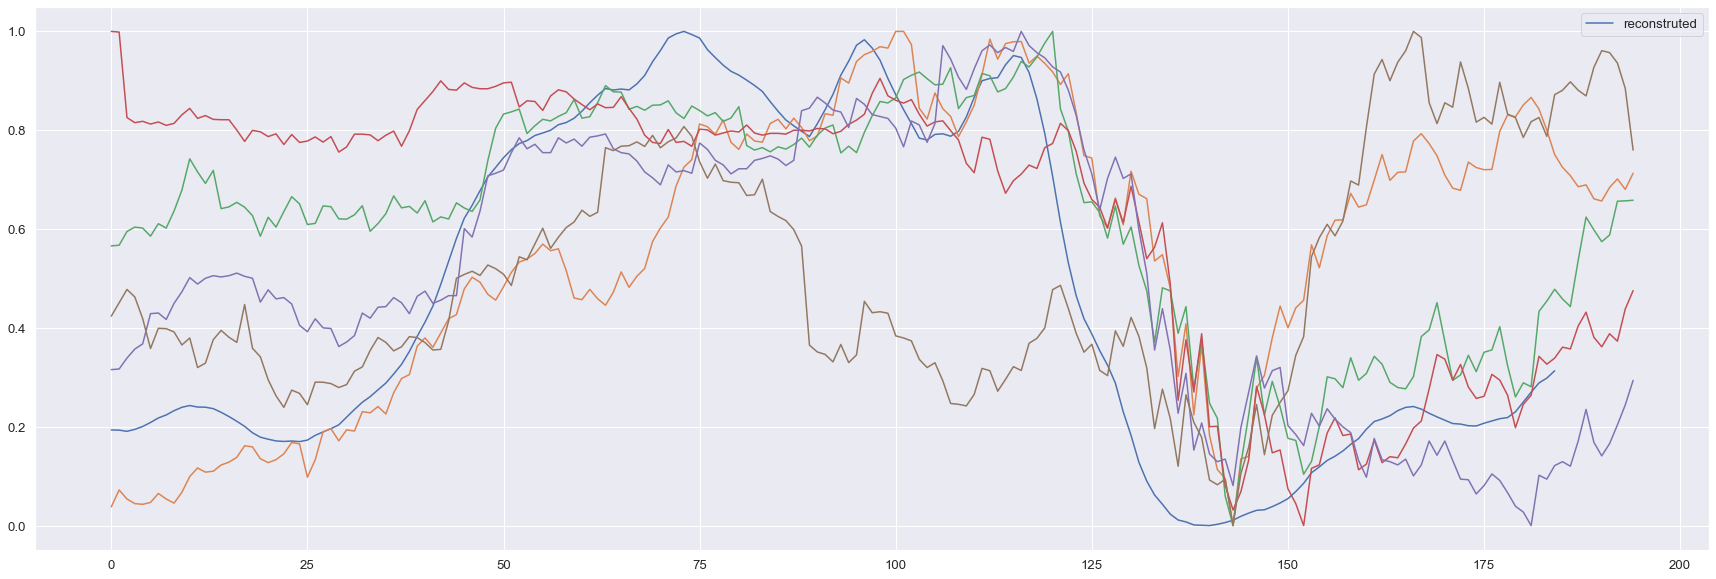

In [ ]:
l_test_encoded = encoder.predict(l_x_test)
l_test_encoded_scaled = sc.fit_transform(l_test_encoded)
plt.plot(l_test_encoded_scaled,label='reconstruted')
plt.plot(l_test_scaled.values[:])
plt.legend()

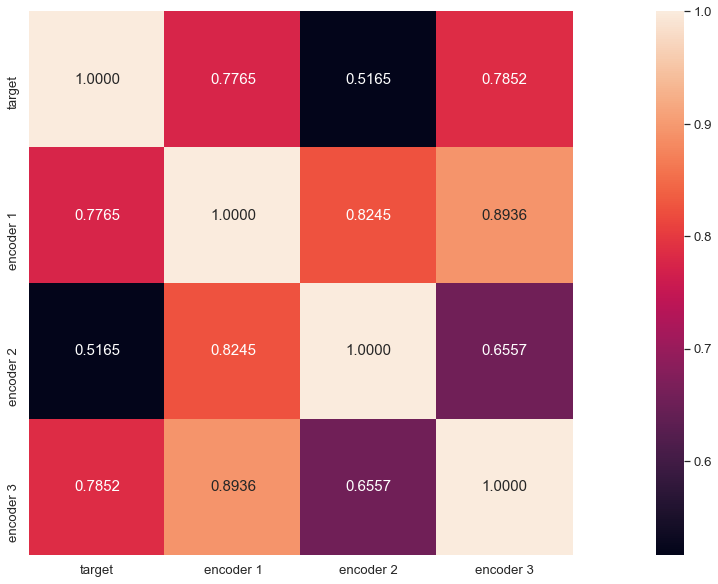

In [ ]:
df4 = pd.DataFrame()
df4['target'] = y_test_encoded
df4['encoder 1'] = test_encoded_scaled
df4['encoder 2'] = c_test_encoded_scaled
df4['encoder 3'] = l_test_encoded_scaled
cm = np.corrcoef(df4.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df4.columns,xticklabels=df4.columns)
#plt.tight_layout()
#plt.savefig('corr_mat.png', dpi=300)

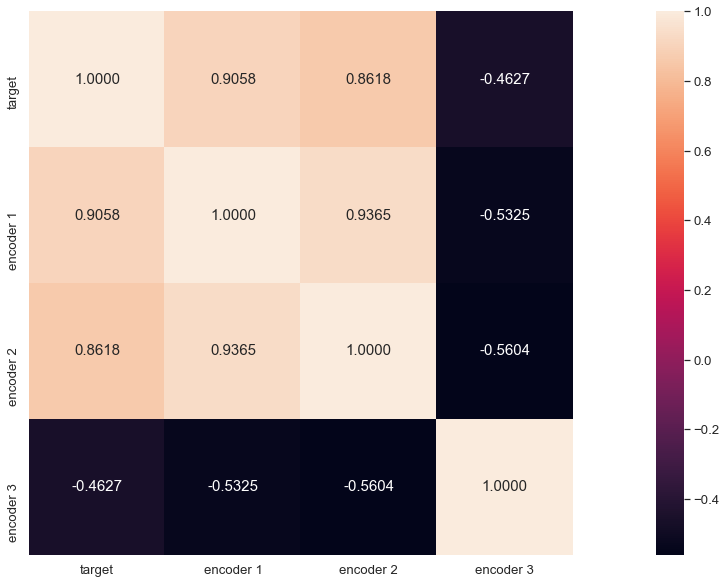

In [ ]:
df5 = pd.DataFrame()
df5['target'] = y_train_encoded
df5['encoder 1'] = train_encoded_scaled
df5['encoder 2'] = c_train_encoded_scaled
df5['encoder 3'] = l_train_encoded_scaled
cm = np.corrcoef(df5.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df5.columns,xticklabels=df5.columns)
#plt.tight_layout()
#plt.savefig('corr_mat.png', dpi=300)

Add new encoders into the model

In [ ]:
compressed_train['c_encoder'] = c_train_encoded
compressed_train['l_encoder'] = l_train_encoded

compressed_test['c_encoder'] = c_test_encoded
compressed_test['l_encoder'] = l_test_encoded

In [ ]:
# Train data
x_train_encoded_3 = np.array(compressed_train[['encoder',10,9,'l_encoder','c_encoder']])
#x_train_encoded_3 = np.array(compressed_train[['encoder',23,22,'l_encoder','c_encoder']])
#y_train_encoded = np.array(compressed_train['target'])
x_train_encoded_3 = x_train_encoded_3.reshape(x_train_encoded_3.shape[0],x_train_encoded_3.shape[1],1)

# Test Data
x_test_encoded_3 = np.array(compressed_test[['encoder',10,9,'l_encoder','c_encoder']])
#x_test_encoded_3 = np.array(compressed_test[['encoder',23,22,'l_encoder','c_encoder']])
#y_test_encoded = np.array(compressed_test['target'])
x_test_encoded_3 = x_test_encoded_3.reshape(x_test_encoded_3.shape[0],x_test_encoded_3.shape[1],1)

In [ ]:
history_3 = model2.fit(x_train_encoded_3, y_train_encoded, epochs=50, batch_size= 16, validation_split=0.1, callbacks=[es], verbose=1)

Train on 817 samples, validate on 91 samples
Epoch 1/50
817/817 [==============================] - 0s 430us/step - loss: 0.0078 - val_loss: 0.0020
Epoch 2/50
817/817 [==============================] - 0s 426us/step - loss: 0.0049 - val_loss: 0.0023
Epoch 3/50
817/817 [==============================] - 0s 491us/step - loss: 0.0045 - val_loss: 0.0017
Epoch 4/50
817/817 [==============================] - 0s 425us/step - loss: 0.0042 - val_loss: 0.0114
Epoch 5/50
817/817 [==============================] - 0s 447us/step - loss: 0.0042 - val_loss: 0.0028
Epoch 6/50
817/817 [==============================] - 0s 441us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 7/50
817/817 [==============================] - 0s 437us/step - loss: 0.0042 - val_loss: 0.0058
Epoch 8/50
817/817 [==============================] - 0s 465us/step - loss: 0.0037 - val_loss: 0.0029
Epoch 9/50
817/817 [==============================] - 0s 475us/step - loss: 0.0038 - val_loss: 0.0078
Epoch 10/50
817/817 [================

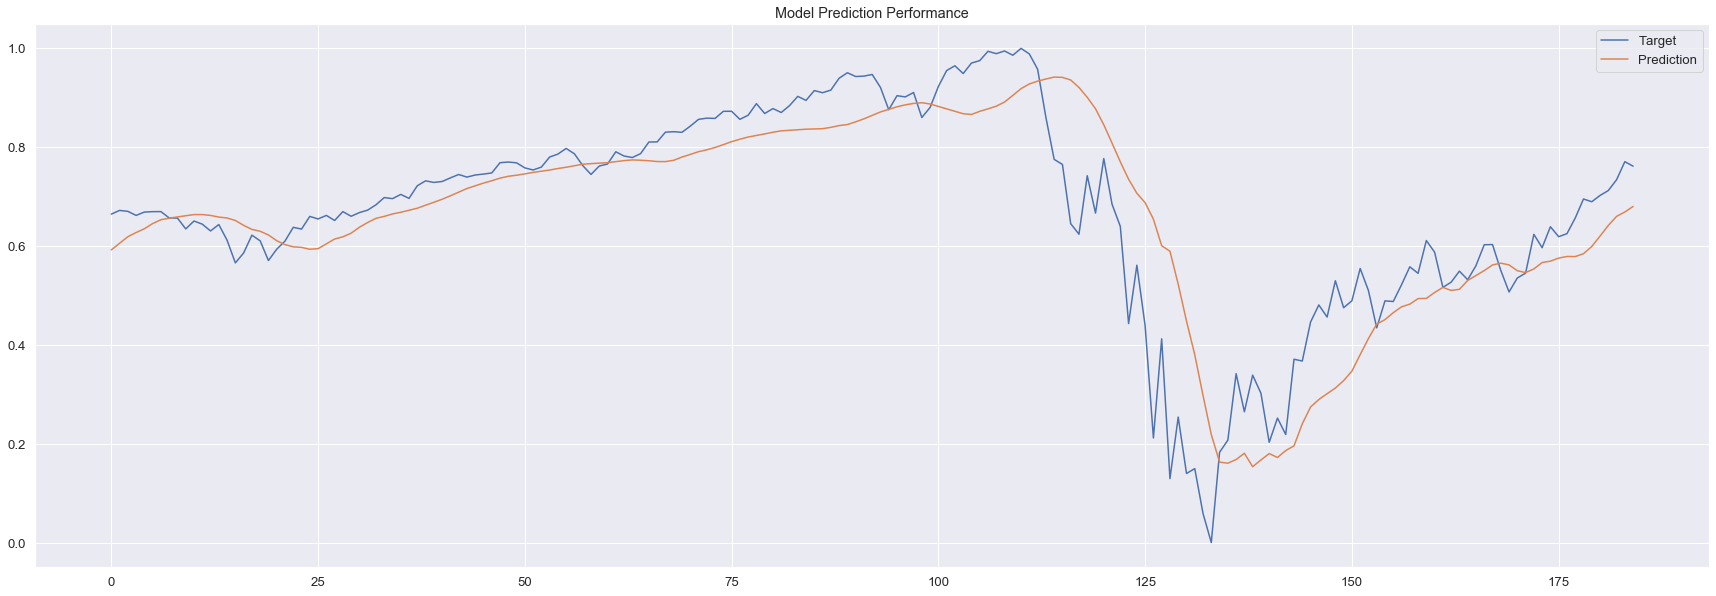

In [ ]:
test_prediction = model2.predict(x_test_encoded_3)
plt.plot(y_test_encoded,label='Target')
plt.plot(test_prediction,label='Prediction')
plt.title('Model Prediction Performance')
plt.legend()

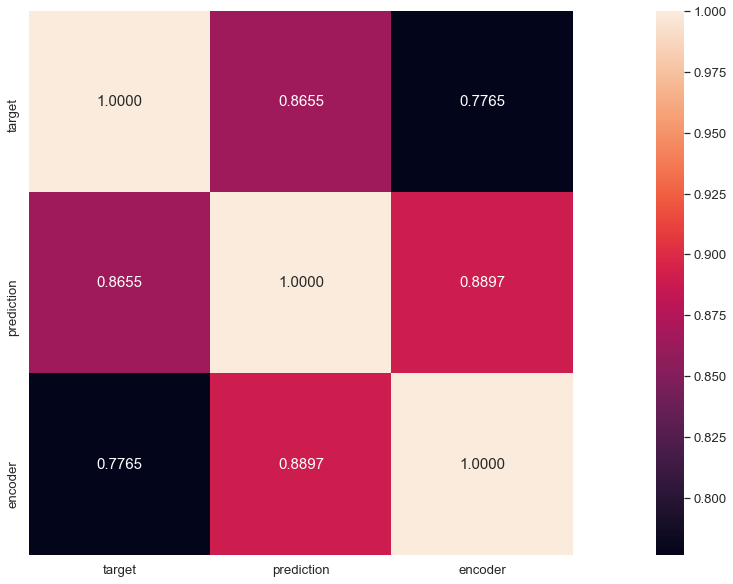

In [ ]:
df6 = pd.DataFrame()
df6['target'] = y_test_encoded
df6['prediction'] = test_prediction.reshape(test_prediction.shape[0])
df6['encoder'] = test_encoded

cm = np.corrcoef(df6.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df6.columns,xticklabels=df6.columns)
#plt.tight_layout()
#plt.savefig('corr_mat.png', dpi=300)